In [4]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display, Markdown
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, BaseMessage,ToolMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langchain_community.vectorstores import Chroma, FAISS
from typing import TypedDict,Annotated,Literal
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

import os


load_dotenv()

True

In [5]:
os.environ['LANGCHAIN_PROJECT']="Agentic RAG"

In [6]:
gpt_llm= ChatOpenAI(model="gpt-4o-mini")


In [7]:
# Get the directory where the notebook is located
rental_dir = os.path.dirname(os.path.abspath("__file__"))
pdf_path = os.path.join(rental_dir, "RentalConditions.pdf")


pdf_loader= PyPDFLoader(pdf_path)
pdf_documents=pdf_loader.load()
splitter=RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
pdf_splitted=splitter.split_documents(pdf_documents)

embeddings=OpenAIEmbeddings(model="text-embedding-3-small",dimensions=1024)
chromadatabase=Chroma.from_documents(pdf_splitted,embeddings)
chromdb_retrieved_docs=chromadatabase.as_retriever(search_kwargs={"k": 3})
retriver_tool_car_rental=create_retriever_tool(chromdb_retrieved_docs,"Rental_Car_Retriever", "Rental car information to be pulled from this document")

In [8]:
# Get the directory where the notebook is located
arxhiv_dir = os.path.dirname(os.path.abspath("__file__"))
pdf_path = os.path.join(arxhiv_dir, "1706.03762v7.pdf")


pdf_loader= PyPDFLoader(pdf_path)
pdf_documents=pdf_loader.load()
splitter=RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
pdf_splitted=splitter.split_documents(pdf_documents)

embeddings=OpenAIEmbeddings(model="text-embedding-3-small",dimensions=1024)
faissdatabase=FAISS.from_documents(pdf_splitted,embeddings)
faiss_retrieved_docs=faissdatabase.as_retriever(search_kwargs={"k": 3})
retriver_tool_arxhiv=create_retriever_tool(faiss_retrieved_docs,"Arxhiv_Retriever", "Arxhiv retrieval for research document")

In [9]:
tools=[retriver_tool_car_rental,retriver_tool_arxhiv]

llm_tools=gpt_llm.bind_tools(tools)

In [10]:
# class ToolState(TypedDict):
#     question: str
#     answer: str

class ToolCaller(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    grader: str
    
    

In [11]:
class Grader(BaseModel):
        grader:Literal["Yes","No"] = Field(description="Document retreival relevance checker")

In [12]:
structured_output=gpt_llm.with_structured_output(Grader)

In [13]:
def agent_assistant(state:ToolCaller)-> ToolCaller:
    """LLM node that may answer or request a tool call"""
    
    prompt=f"You are an AI assistant who makes different tool calls and provide answers to the users based on user query: {state['messages']}."

    result=llm_tools.invoke(prompt)
    return {"messages":[result]}

In [14]:
def retriever_agent(state:ToolCaller)-> ToolCaller:
    """You are a document grader whose role is to check if the document is relavant based on the user query"""

    for msg in state["messages"]:
            if isinstance(msg, ToolMessage):
                tool_message=msg.content
            if isinstance(msg, HumanMessage):
                human_message=msg.content

    prompt=f"""From the given user_query - \n {human_message}. \n These are context: \n {tool_message} fetched from the document. 
    Based on the user query and context provided, please classify the grader of question as 'Yes' or 'No'. Do look for bad and short queries by users."""

    response=structured_output.invoke(prompt)
    
    return {"grader":response.grader}

In [15]:
def grader_condition(state:ToolCaller)-> Literal["rewrite_agent","generate_agent"]:
    """Condition to help check the rewrite agent or generate agent"""

    if state["grader"]=="Yes":
        return "generate_agent"
    else:
        return "rewrite_agent"

In [16]:
def rewrite_agent(state:ToolCaller)-> ToolCaller:
    """You are a rewrite agent which helps in generating/rewriting the user query."""

    for msg in state["messages"]:
            if isinstance(msg, HumanMessage):
                human_message=msg.content

    prompt=f"""From the given user_query, please help in rewite the user query- \n {human_message}.'"""

    response=gpt_llm.invoke(prompt)
    
    return {"messages":[response]}

In [17]:
def generate_agent(state:ToolCaller)-> ToolCaller:
    """You are a generation agent which helps in generating the final output from the relavant documents.
    Args: 
        state[messages] - current state 
    Returns:
        dictionary - update state messages

    """

    for msg in state["messages"]:
            if isinstance(msg, ToolMessage):
                tool_message=msg.content
            if isinstance(msg, HumanMessage):
                human_message=msg.content

    prompt=f"""From the given user_query - \n {human_message}. \n These are context: \n {tool_message} fetched from the document. 
    Please help in giving the output of the user question."""

    response=gpt_llm.invoke(prompt)
    
    return {"messages":[response]}

In [18]:
graph=StateGraph(ToolCaller)


In [19]:
graph.add_node("agent_assistant",agent_assistant)
graph.add_node("tools",ToolNode(tools))
graph.add_node("retriever_agent",retriever_agent)
graph.add_node("rewrite_agent",rewrite_agent)
graph.add_node("generate_agent",generate_agent)

graph.add_edge(START, "agent_assistant")
graph.add_conditional_edges("agent_assistant",tools_condition)
graph.add_edge("tools","retriever_agent")
graph.add_conditional_edges("retriever_agent",grader_condition)
graph.add_edge("rewrite_agent","agent_assistant")
graph.add_edge("generate_agent",END)


In [20]:
workflow = graph.compile()

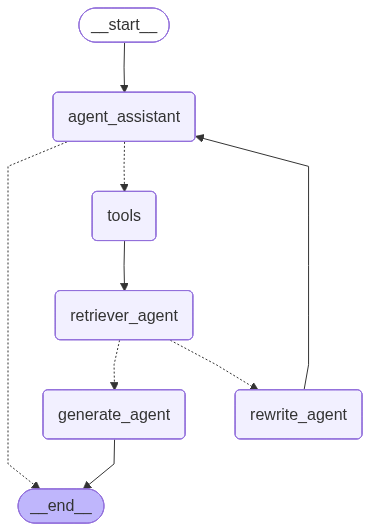

In [21]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [22]:
config = {
    "run_name":"Agentic Rag"
}
result = workflow.invoke({"messages":"contact points for car rental?"}, config=config)

In [23]:
result

{'messages': [HumanMessage(content='contact points for car rental?', additional_kwargs={}, response_metadata={}, id='4eaceb51-fff5-4e05-a5a8-d88382d8d6c0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TgDtv6gROoRgGA0y8NerOt9n', 'function': {'arguments': '{"query":"contact points for car rental"}', 'name': 'Rental_Car_Retriever'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 162, 'total_tokens': 185, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CRpKw32xydJ2MbsY8Ig1TACFMvbRF', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--35c5ef44-570d-48ab-80f9-a3f0fd2d6a01-0', tool_calls=[{'name': 'Rental_Car_Retri

In [26]:
Markdown(result['messages'][-1].content)

Here are the contact points for car rental assistance:

**Emergency Telephone Numbers:**
- For English (UK): +44 203 885 0130
- For English (US): 01-855 478 5048
- For Spanish: +34 871 180 639
- For German: +49 30 311 97084
- For French: +33 1 865 76529

Feel free to reach out to these numbers if you need support when you arrive at your pick-up location or during the rental period.